<a href="https://colab.research.google.com/github/JiwonHae94/Tensorflow-For-Beginners/blob/main/Tensorflow_Beginners_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# efficientnet
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

# load pre-trained weights
# drop_connect_rate : dropout rate for stochastic depth -> default = 0.2
model = EfficientNetB0(weights = 'imagenet', drop_connect_rate = 0.4)

21848064/21834768 [==============================] - 0s 0us/step


In [3]:
# img size determined by model
IMG_SIZE = 224

In [4]:
tf.__version__

'2.8.0'

In [5]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
  print("Device:", tpu.master())
  strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [6]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteU8QOVH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteU8QOVH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [7]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

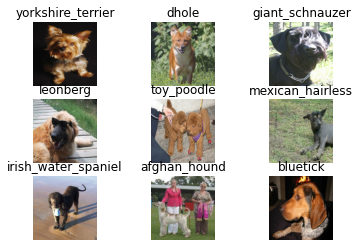

In [8]:
import matplotlib.pyplot as plt

def format_label(label):
  string_label = label_info.int2str(label)
  return string_label.split("-")[1]

label_info = ds_info.features["label"]
for i, (image,label) in enumerate(ds_train.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(f"{format_label(label)}")
  plt.axis("off")


In [9]:
# augment data
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

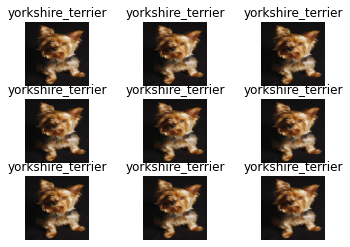

In [10]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [11]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(
    input_preprocess, num_parallel_calls = tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size = batch_size, drop_remainder = True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size = batch_size, drop_remainder = True)


In [12]:
# Training from scratch
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top = True, weights = None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]
    )

model.summary()
epochs = 1
hist = model.fit(ds_train, epochs = epochs, validation_data = ds_test, verbose = 2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
187/187 - 140s - loss: 4.9555 - accuracy: 0.0130 - val_loss: 5.1679 - val_accuracy: 0.0139 - 140s/epoch - 750ms/step


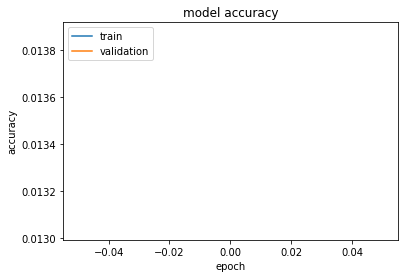

In [13]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc = "upper left")
    plt.show()

plot_hist(hist)

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/25
187/187 - 52s - loss: 3.5499 - accuracy: 0.3702 - val_loss: 1.0544 - val_accuracy: 0.6846 - 52s/epoch - 280ms/step
Epoch 2/25
187/187 - 36s - loss: 1.8293 - accuracy: 0.5277 - val_loss: 0.8169 - val_accuracy: 0.7512 - 36s/epoch - 192ms/step
Epoch 3/25
187/187 - 37s - loss: 1.5465 - accuracy: 0.5739 - val_loss: 0.7999 - val_accuracy: 0.7591 - 37s/epoch - 199ms/step
Epoch 4/25
187/187 - 36s - loss: 1.4408 - accuracy: 0.5974 - val_loss: 0.7749 - val_accuracy: 0.7691 - 36s/epoch - 194ms/step
Epoch 5/25
187/187 - 36s - loss: 1.3793 - accuracy: 0.6106 - val_loss: 0.7980 - val_accuracy: 0.7605 - 36s/epoch - 193ms/step
Epoch 6/25
187/187 - 36s - loss: 1.3703 - accuracy: 0.6138 - val_loss: 0.7927 - val_accuracy: 0.7640 - 36s/epoch - 193ms/step
Epoch 7/25
187/187 - 37s - loss: 1.3278 - accuracy: 0.6262 - val_loss: 0.8213 - val_accuracy: 0.7564 - 37s/epoch - 196ms/step
Epoch 8/25
187/187 - 36s - loss: 1.3118 - accuracy: 0

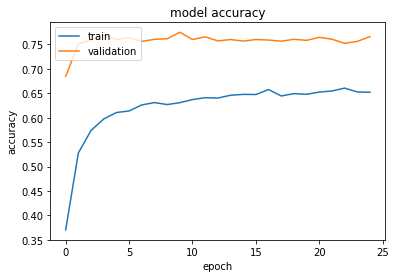

In [14]:
# transfer learning from pre-trained weights
def build_model(num_classes):
    inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top = False, input_tensor = x, weights = "imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name = "top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation = "softmax", name = "pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name = "EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"]
    )
    return model

with strategy.scope():
    model = build_model(num_classes = NUM_CLASSES)
  
epochs = 25
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)


Epoch 1/40
187/187 - 49s - loss: 0.9602 - accuracy: 0.7211 - val_loss: 0.7371 - val_accuracy: 0.7933 - 49s/epoch - 261ms/step
Epoch 2/40
187/187 - 39s - loss: 0.8422 - accuracy: 0.7492 - val_loss: 0.7450 - val_accuracy: 0.7942 - 39s/epoch - 207ms/step
Epoch 3/40
187/187 - 38s - loss: 0.7759 - accuracy: 0.7648 - val_loss: 0.7384 - val_accuracy: 0.7956 - 38s/epoch - 206ms/step
Epoch 4/40
187/187 - 39s - loss: 0.7270 - accuracy: 0.7794 - val_loss: 0.7452 - val_accuracy: 0.7908 - 39s/epoch - 206ms/step
Epoch 5/40
187/187 - 39s - loss: 0.6799 - accuracy: 0.7876 - val_loss: 0.7307 - val_accuracy: 0.7944 - 39s/epoch - 208ms/step
Epoch 6/40
187/187 - 39s - loss: 0.6527 - accuracy: 0.7983 - val_loss: 0.7438 - val_accuracy: 0.7927 - 39s/epoch - 206ms/step
Epoch 7/40
187/187 - 39s - loss: 0.6046 - accuracy: 0.8093 - val_loss: 0.7486 - val_accuracy: 0.7926 - 39s/epoch - 207ms/step
Epoch 8/40
187/187 - 39s - loss: 0.5613 - accuracy: 0.8216 - val_loss: 0.7462 - val_accuracy: 0.7937 - 39s/epoch - 206

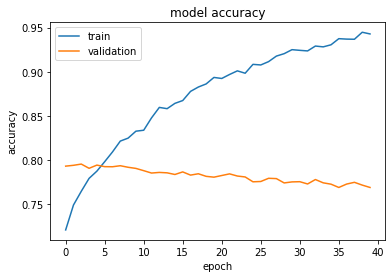

In [15]:
def unfreeze_model(model):
    # unfreeze top N layers, N = 20
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(
        optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"]
    )

unfreeze_model(model)
epochs = 40 
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [18]:
# convert model from keras to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('efficientnetb0.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpb9hc_ugh/assets


INFO:tensorflow:Assets written to: /tmp/tmpb9hc_ugh/assets
